# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Intro</span></span></center></h1> 

In this notebook, we address the project with transfer learning.

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

| category  | emotion  |
|:---:|:---|
| 0  | Angry  |
| 1  |  Disgust |
| 2  |  Fear |
| 3  |  Happy |
| 4  |  Sad |
| 5  |  Surprise |
| 6  | Neutral |

[DrCapa](https://www.kaggle.com/drcapa) provided an excellent [notebook](https://www.kaggle.com/code/drcapa/facial-expression-eda-cnn/notebook), which presents a concise but nice data analysis, and a custom CNN model that achieves a testing accuracy of about 55%. Building on this work, I wanted to see if I can improve this by using pretrained MobileNet model, fine-tuning it, and including some data augmentation.

Please upvote the notebook up if you find it to be helpful. And I would be happy to read your comments and suggestions. Thanks in advance!

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;">Libraries</span></center></h1> 
## We load some standard libraries and packages of sklearn and keras.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras import models
from keras.utils import to_categorical, np_utils

from tensorflow import convert_to_tensor
from tensorflow.image import grayscale_to_rgb
from tensorflow.data import Dataset
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [2]:
#import tensorflow as tf
#tf.__version__

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load & Prepare Data</span></span></center></h1> 

In [3]:
# Define the input path and show all files
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
os.listdir(path)

['icml_face_data.csv',
 'fer2013.tar.gz',
 'example_submission.csv',
 'train.csv',
 'test.csv']

In [4]:
# Load the image data with labels.
data = pd.read_csv(path+'icml_face_data.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
#Overview 
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [8]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

## Define training, validation and test data:

In [9]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the images:

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [11]:
#As the pretrained model expects rgb images, we convert our grayscale images with a single channel to pseudo-rgb images with 3 channels
train_images_rgb = grayscale_to_rgb(convert_to_tensor(train_images))
val_images_rgb = grayscale_to_rgb(convert_to_tensor(val_images))
test_images_rgb =  grayscale_to_rgb(convert_to_tensor(test_images))

In [12]:
# Data Augmentation using ImageDataGenerator

#sources:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
#https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_rgb_datagen = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)

train_rgb_datagen.fit(train_images_rgb)

## Encoding of the target value:

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Some Examples</span></span></center></h1> 

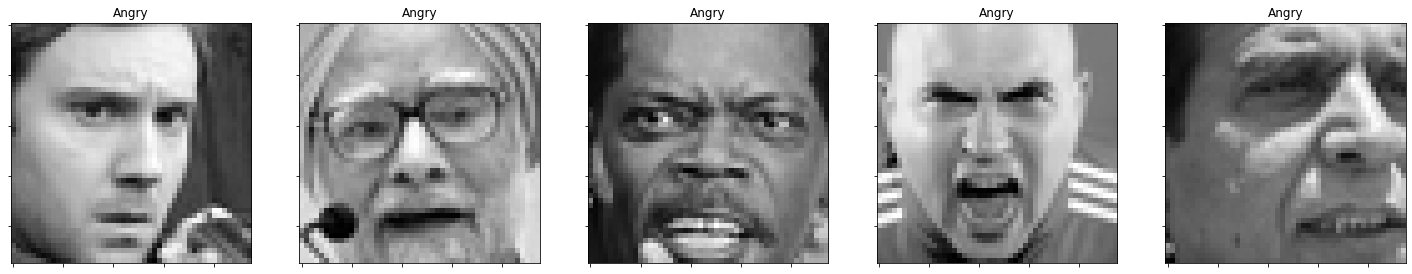

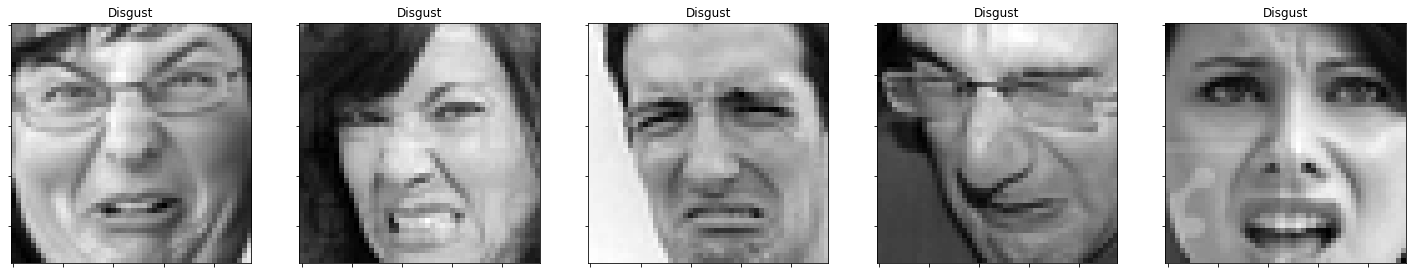

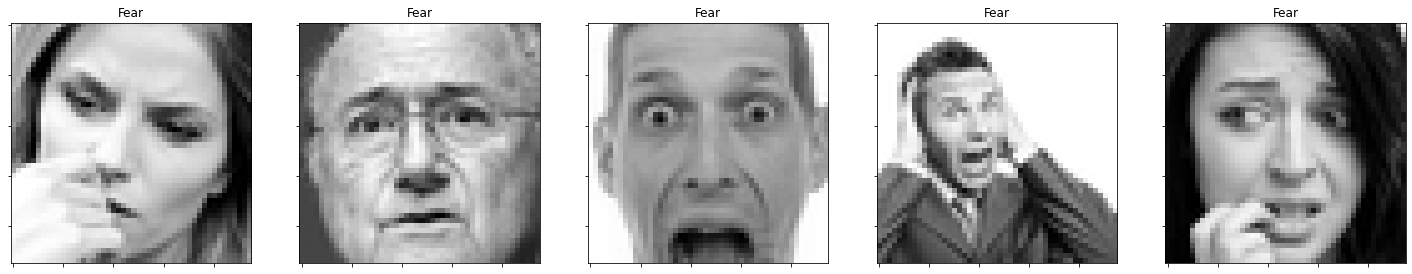

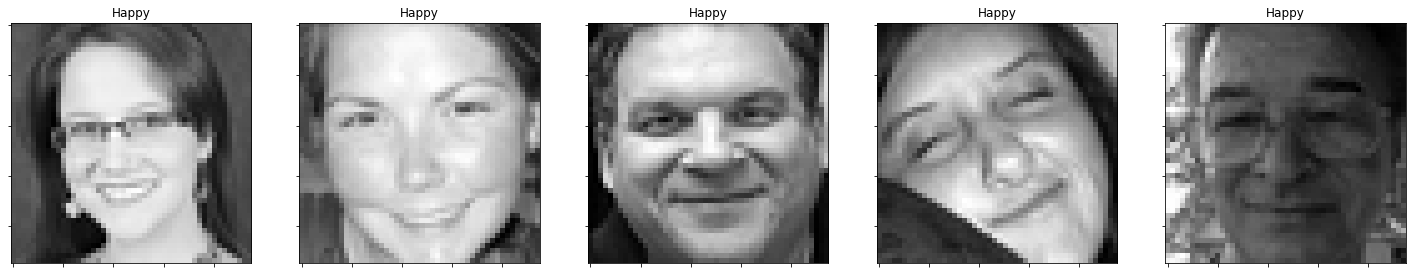

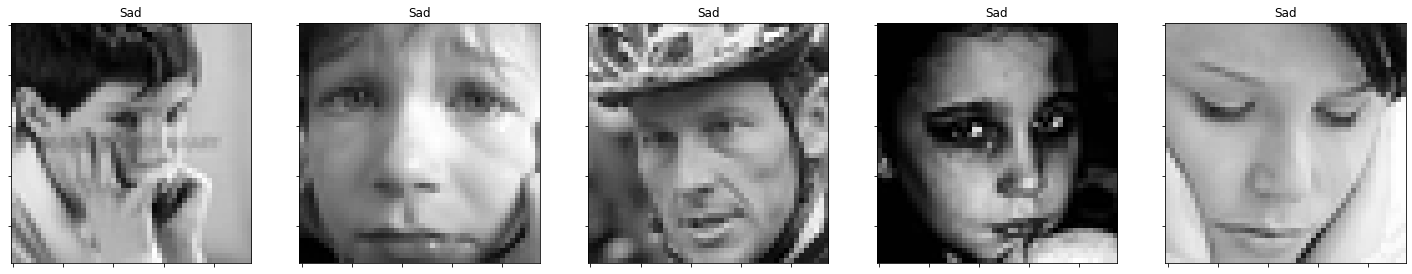

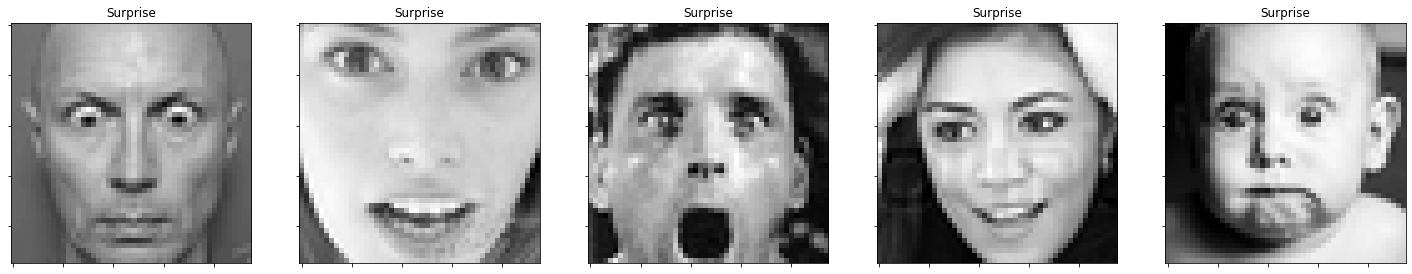

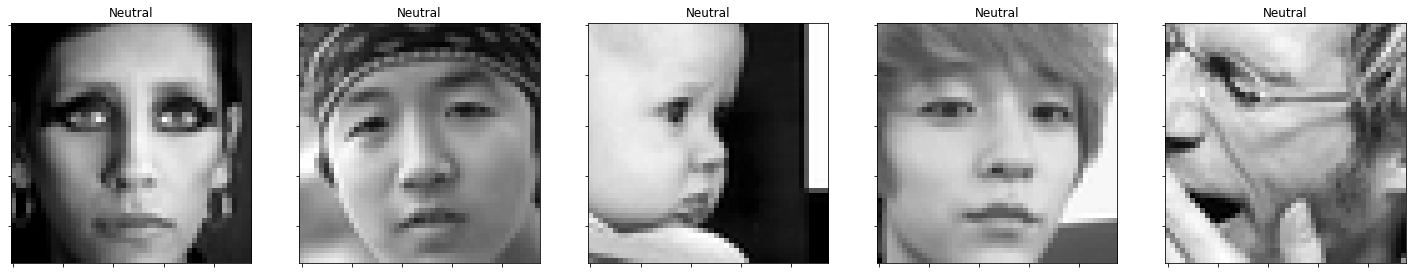

In [14]:
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
plot_examples(label=0)
plot_examples(label=1)
plot_examples(label=2)
plot_examples(label=3)
plot_examples(label=4)
plot_examples(label=5)
plot_examples(label=6)

In [15]:
#In case we may want to save some examples:

from PIL import Image

def save_all_emotions(channels=1, imgno=0):
    for i in range(7):
        idx = data[data['emotion']==i].index[imgno]
        emotion = emotions[train_labels[idx].argmax()]
        img = train_images[idx]
        if channels == 1:
            img = img.squeeze()
        else: 
            img = grayscale_to_rgb(convert_to_tensor(img)).numpy() #convert to tensor, then to 3ch, back to numpy
        img_shape = img.shape
        #print(f'img shape: {img_shape[0]},{img_shape[1]}, type: {type(img)}') #(48,48)
        img = img * 255
        img = img.astype(np.uint8)
        suf = '_%d_%d_%d'%(img_shape[0],img_shape[1],channels)
        os.makedirs('examples'+suf, exist_ok=True)
        fname = os.path.join('examples'+suf, emotion+suf+'.png')
        Image.fromarray(img).save(fname)
        print(f'saved: {fname}')

save_all_emotions(channels=3,imgno=0)

saved: examples_48_48_3/Angry_48_48_3.png
saved: examples_48_48_3/Disgust_48_48_3.png
saved: examples_48_48_3/Fear_48_48_3.png
saved: examples_48_48_3/Happy_48_48_3.png
saved: examples_48_48_3/Sad_48_48_3.png
saved: examples_48_48_3/Surprise_48_48_3.png
saved: examples_48_48_3/Neutral_48_48_3.png


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Distribution Of Labels & Class Weights </span></span></center></h1> 

In [16]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

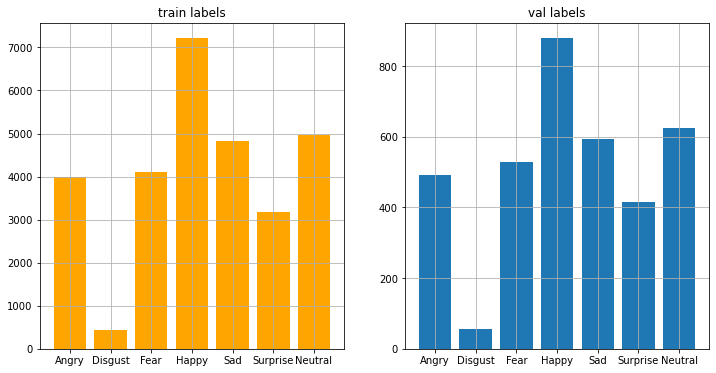

In [17]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

## Calculate the class weights of the label distribution:

In [18]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Model</span></span></center></h1>

## General defintions and helper functions

In [19]:
#Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [20]:
#General shape parameters
IMG_SIZE = 48
NUM_CLASSES = 7
BATCH_SIZE = 64

In [21]:
#A plotting function to visualize training progress
def render_history(history, suf=''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.95,
                        top=0.9,
                        wspace=0.4)
    
    ax1.set_title("Losses")
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('value of the loss function')
    ax1.legend()

    ax2.set_title("Accuracies")
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('value of accuracy')
    ax2.legend()
    
    plt.show()
    suf = '' if suf == '' else '_'+suf
    fig.savefig('loss_and_acc'+suf +'.png')

## Model construction

In [22]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

#By specifying the include_top=False argument, we load a network that 
#doesn't include the  classification layers at the top, which is ideal for feature extraction.
base_net = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

#plot_model(base_net, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet_full.png')

17227776/17225924 [==============================] - 0s 0us/step


## For these small images, mobilenet is a very large model.  Observing that there is nothing left to convolve further, we take the model only until the 12.block

In [23]:
base_model = Model(inputs = base_net.input,outputs = base_net.get_layer('conv_pw_12_relu').output, name = 'mobilenet_trunc')
#this is the same as:
#base_model = Model(inputs = base_net.input,outputs = base_net.layers[-7].output)

#plot_model(base_model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet_truncated.png')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
mobilenet_trunc (Functional) (None, 1, 1, 1024)        2162880   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
pred (Dense)                 (None, 7)                 7175      
Total params: 2,170,055
Trainable params: 2,152,263
Non-trainable params: 17,792
_________________________________________________________________


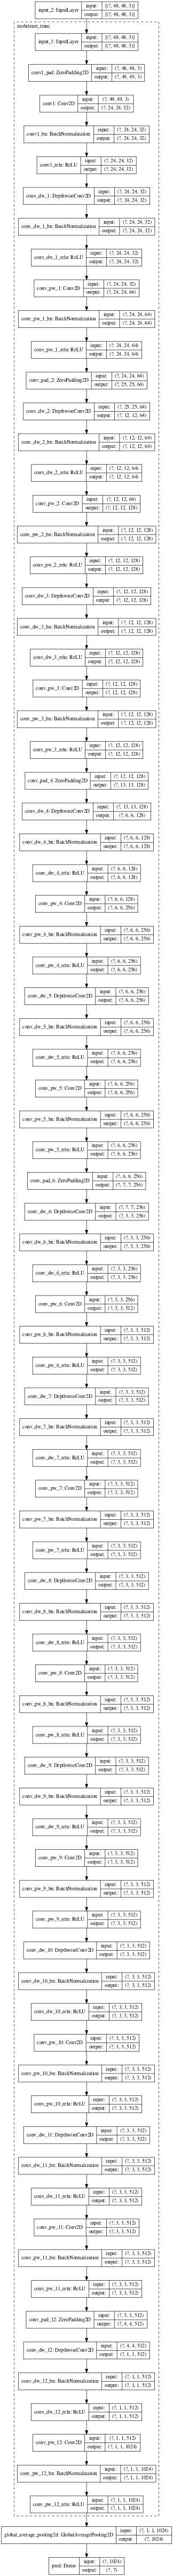

In [24]:
#from: https://www.tensorflow.org/tutorials/images/transfer_learning
from tensorflow.keras import Sequential, layers
from tensorflow.keras import Input, Model
#from tensor

#base_model.trainable = False

#This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. 
#To rescale them, use the preprocessing method included with the model.
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#Add a classification head: To generate predictions from the block of features, 
#average over the spatial 2x2 spatial locations,  using a tf.keras.layers.GlobalAveragePooling2D layer 
#to convert the features to a single 1280-element vector per image.
global_average_layer = GlobalAvgPool2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

#Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. 
#You don't need an activation function here because this prediction will be treated as a logit, 
#or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.
prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

#Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers 
#using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.
inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#inputs_pp = preprocess_input(inputs_aug)
#x = base_model(inputs_pp, training=False)
x = base_model(inputs_raw, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = Model(inputs=inputs_raw, outputs= outputs)

model.summary()
plot_model(model, 
           show_shapes=True, 
           show_layer_names=True, 
           expand_nested=True, 
           dpi=50, 
           to_file='MobileNet12blocks_structure.png')

In [25]:
#Train the classification head:

#base_model.trainable = True #if we included the model layers, but not the model itself, this doesn't have any effect
for layer in base_model.layers[:]:
    layer.trainable = False
#for layer in base_model.layers[81:]:
#    layer.trainable = True

optims = {
    'sgd': optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01),
    'adam': optimizers.Adam(0.01),
    'nadam': optimizers.Nadam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
}

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims['adam'],
        metrics=['accuracy']
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
mobilenet_trunc (Functional) (None, 1, 1, 1024)        2162880   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
pred (Dense)                 (None, 7)                 7175      
Total params: 2,170,055
Trainable params: 7,175
Non-trainable params: 2,162,880
_________________________________________________________________


In [26]:
initial_epochs = 5
# total_epochs = initial_epochs + 5
history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                 train_labels, 
                                                 batch_size=BATCH_SIZE),
                              validation_data=(val_images_rgb, 
                                               val_labels),
                              class_weight = class_weight,
                              steps_per_epoch=len(train_images) / BATCH_SIZE,
                              #initial_epoch = history.epoch[-1],
                              #epochs = total_epochs,
                              epochs = initial_epochs,
                              callbacks=callbacks,
                              use_multiprocessing=True)

Epoch 1/5
449/448 [==============================] - 23s 51ms/step - loss: 0.3093 - accuracy: 0.3429 - val_loss: 1.8735 - val_accuracy: 0.3892
Epoch 2/5
449/448 [==============================] - 22s 49ms/step - loss: 0.2979 - accuracy: 0.3632 - val_loss: 1.9810 - val_accuracy: 0.3461
Epoch 3/5
449/448 [==============================] - 21s 47ms/step - loss: 0.2963 - accuracy: 0.3704 - val_loss: 1.9980 - val_accuracy: 0.4018
Epoch 4/5
449/448 [==============================] - 22s 50ms/step - loss: 0.3032 - accuracy: 0.3677 - val_loss: 2.1077 - val_accuracy: 0.3770
Epoch 5/5
449/448 [==============================] - 22s 49ms/step - loss: 0.2978 - accuracy: 0.3697 - val_loss: 1.8218 - val_accuracy: 0.3954


## Fine-tuning

Here I wanted to find out whether the training converges better or faster if the training is performed iteratively,
whereby first the upper layers of the base_model is fine-tuned with a moderately slow learning rate (1e-3),
then the entire base model will be fine-tuned in a second round with a small learning rate (1e-4).
In the non-iterative approach, the whole base_model is trained with that smal learning rate (1e-4).
However I did not see evidence for any advantage of the iterative approach, 
therefore I've set the 'iterative_finetuning' switch to False.

In [27]:
iterative_finetuning = False 

## First iteration: partial fine-tuning of the base_model

In [28]:
if iterative_finetuning:
    #fine-tune the top layers (blocks 7-12):

    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))
    #base_model.trainable = True #if we included the model layers, but not the model itself, this doesn't have any effect
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-37:]: #blocks 7-12
      layer.trainable = True

    optims = {
        'sgd': optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01),
        'adam': optimizers.Adam(0.001),
        'nadam': optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    }

    model.compile(
            loss='categorical_crossentropy',
            optimizer=optims['adam'],
            metrics=['accuracy']
    )

    model.summary()

In [29]:
if iterative_finetuning:
    fine_tune_epochs = 40
    total_epochs =  history.epoch[-1] + fine_tune_epochs

    history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                     train_labels, 
                                                     batch_size=BATCH_SIZE),
                                  validation_data=(val_images_rgb, 
                                                   val_labels),
                                  class_weight = class_weight,
                                  steps_per_epoch=len(train_images) / BATCH_SIZE,
                                  initial_epoch = history.epoch[-1],
                                  epochs = total_epochs,
                                  callbacks=callbacks,
                                  use_multiprocessing=True)

In [30]:
if iterative_finetuning:
    test_loss, test_acc = model.evaluate(test_images_rgb, test_labels) #, test_labels
    print('test caccuracy:', test_acc)

In [31]:
if iterative_finetuning:
    render_history(history, 'mobilenet12blocks_wdgenaug_finetuning1')

## Second Iteration (or the main iteration, if iterative_finetuning was set to False): fine-tuning of the entire base_model

In [32]:
if iterative_finetuning:
    ftsuf = 'ft_2'
else:
    ftsuf = 'ft_atonce'

In [33]:
#fine-tune all layers

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
#base_model.trainable = True #if we included the model layers, but not the model itself, this doesn't have any effect
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[:]:
  layer.trainable = True

optims = {
    'sgd': optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01),
    'adam': optimizers.Adam(0.0001),
    'nadam': optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
}

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims['adam'],
        metrics=['accuracy']
)

model.summary()

Number of layers in the base model:  81
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
mobilenet_trunc (Functional) (None, 1, 1, 1024)        2162880   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
pred (Dense)                 (None, 7)                 7175      
Total params: 2,170,055
Trainable params: 2,152,263
Non-trainable params: 17,792
_________________________________________________________________


In [34]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                 train_labels, 
                                                 batch_size=BATCH_SIZE),
                              validation_data=(val_images_rgb, 
                                               val_labels),
                              class_weight = class_weight,
                              steps_per_epoch=len(train_images) / BATCH_SIZE,
                              initial_epoch = history.epoch[-1],
                              epochs = total_epochs,
                              callbacks=callbacks,
                              use_multiprocessing=True)

Epoch 5/104
449/448 [==============================] - 25s 56ms/step - loss: 0.2373 - accuracy: 0.4185 - val_loss: 1.4505 - val_accuracy: 0.4728
Epoch 6/104
449/448 [==============================] - 24s 54ms/step - loss: 0.2106 - accuracy: 0.4788 - val_loss: 1.3257 - val_accuracy: 0.5096
Epoch 7/104
449/448 [==============================] - 24s 54ms/step - loss: 0.1995 - accuracy: 0.5043 - val_loss: 1.2294 - val_accuracy: 0.5411
Epoch 8/104
449/448 [==============================] - 25s 55ms/step - loss: 0.1947 - accuracy: 0.5164 - val_loss: 1.2620 - val_accuracy: 0.5272
Epoch 9/104
449/448 [==============================] - 24s 54ms/step - loss: 0.1886 - accuracy: 0.5320 - val_loss: 1.2909 - val_accuracy: 0.5032
Epoch 10/104
449/448 [==============================] - 24s 54ms/step - loss: 0.1853 - accuracy: 0.5416 - val_loss: 1.1900 - val_accuracy: 0.5634
Epoch 11/104
449/448 [==============================] - 25s 56ms/step - loss: 0.1797 - accuracy: 0.5533 - val_loss: 1.1744 - val_

In [35]:
test_loss, test_acc = model.evaluate(test_images_rgb, test_labels) #, test_labels
print('test caccuracy:', test_acc)

113/113 [==============================] - 0s 4ms/step - loss: 1.0364 - accuracy: 0.6236
test caccuracy: 0.623572051525116


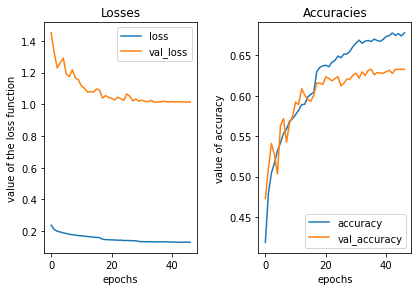

In [36]:
render_history(history, 'mobilenet12blocks_wdgenaug_'+ftsuf)

In [37]:
pred_test_labels = model.predict(test_images_rgb)

In [38]:
model_yaml = model.to_yaml()
with open('MobileNet12blocks_wdgenaug_onrawdata_valacc_' + ftsuf + '.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
    
model.save('MobileNet12blocks_wdgenaug_onrawdata_valacc_' + ftsuf + '.h5')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Results</span></span></center></h1> 

## Analyze the predictions made for the test data

In [39]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

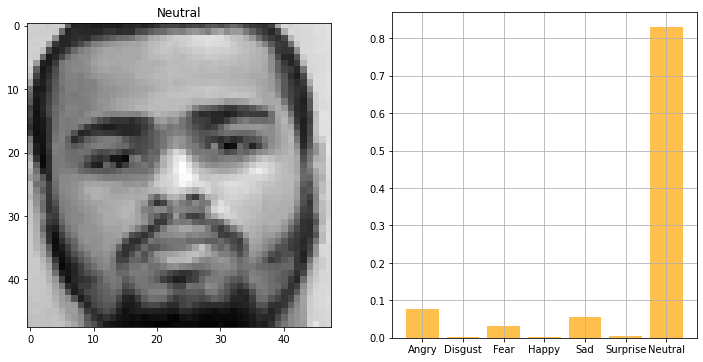

In [40]:
import ipywidgets as widgets
@widgets.interact
def f(x=106):
    #print(x)
    plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, x)

## Make inference for a single image from scratch: 

In [41]:
def predict_emotion_of_image(test_image_array, test_image_label, pred_test_labels, image_number):
    
    input_arr = test_image_array[image_number]/255
    input_arr = input_arr.reshape((48, 48, 1))
    input_arr_rgb =  grayscale_to_rgb(convert_to_tensor(input_arr))
    
    predictions = model.predict(np.array([input_arr_rgb]))
    predictions_f = ['%s:%5.2f'%(emotions[i],p*100) for i,p in enumerate(predictions[0])]
    label = emotions[test_image_label[image_number]]
    return f'Label: {label}\nPredictions: {predictions_f}'

In [42]:
import ipywidgets as widgets
@widgets.interact
def f(x=106):
    result = predict_emotion_of_image(test_image_array, test_image_label, pred_test_labels, x)
    print(result)

Label: Neutral
Predictions: ['Angry: 7.62', 'Disgust: 0.10', 'Fear: 3.06', 'Happy: 0.14', 'Sad: 5.54', 'Surprise: 0.56', 'Neutral:82.98']


## Compare the distribution of labels and predicted labels

In [43]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

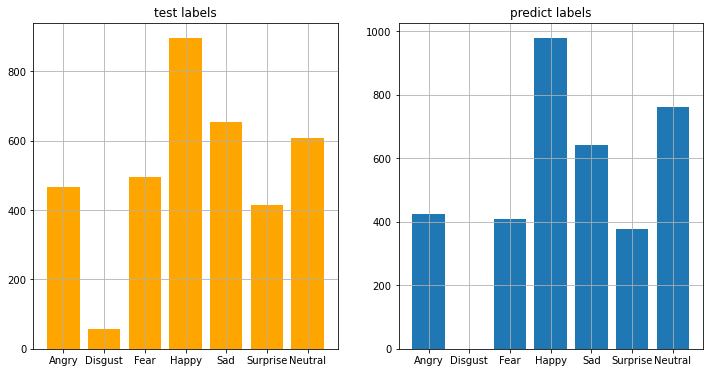

In [44]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyse Wrong Predictions</span></span></center></h1> 

## The accuracy score is about 63% on the test set. Let's try to understand where the model is doing wrong.

In [45]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

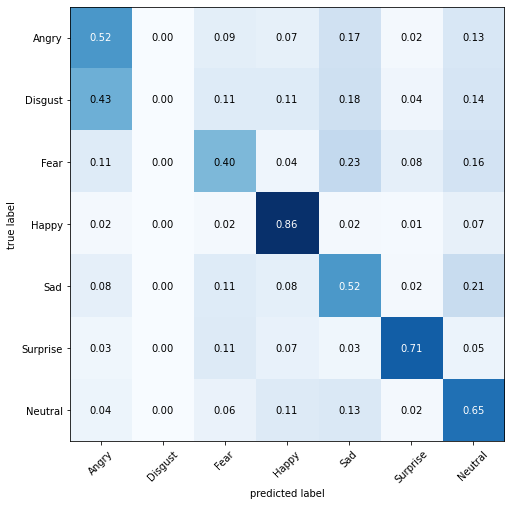

In [46]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()